In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score,classification_report,f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 

import math
import torch
from torch import nn
from torch import optim
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, DataLoader

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.utils.data as utils
from torch.optim import Adam 

In [4]:
trainloader = torch.utils.data.DataLoader(
        datasets.MNIST('MNIST_data/', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('MNIST_data/', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=16, shuffle=True)

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
device = torch.device('cpu')

cuda


In [88]:
def call_pr_loss(a , variance):
    k = len(a[0])
    l = torch.sum(a**2)/ variance**2 /2/k
    return k/2*math.log(2*math.pi) + 0.5*k*math.log(variance) + l

In [7]:
m_200 = 1
m_784 = 1

In [12]:
model = nn.Sequential()
model.add_module('l1', nn.Linear(784, 200))
model.add_module('r1', nn.Sigmoid())
model.add_module('l2', nn.Linear(200, 200))
model.add_module('r2', nn.Sigmoid())
model.add_module('l3', nn.Linear(200, 200))
model.add_module('r3', nn.Sigmoid())

model.add_module('lf', nn.Linear(200, 10))

model.to(device)

Sequential(
  (l1): Linear(in_features=784, out_features=200, bias=True)
  (r1): Sigmoid()
  (l2): Linear(in_features=200, out_features=200, bias=True)
  (r2): Sigmoid()
  (l3): Linear(in_features=200, out_features=200, bias=True)
  (r3): Sigmoid()
  (lf): Linear(in_features=200, out_features=10, bias=True)
)

In [13]:
model.l1.weight[10][10] 

tensor(-0.0105, grad_fn=<SelectBackward>)

In [14]:
def eva(test_loader , model):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data.view(data.size(0), -1)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return (test_loss ,correct / len(test_loader.dataset) )

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

model.train()
step = 0 
loss_history = []
for epoch in range(1, 3):
    for batch_idx, (data, target) in enumerate(trainloader):
        
        data, target = data.to(device), target.to(device)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        output = model(data)
        loss_0 = criterion(output, target)
        loss_1 = call_pr_loss(model.l1.weight , m_784)
        loss_2 = call_pr_loss(model.l2.weight , m_200)
        loss_3 = call_pr_loss(model.l3.weight , m_200)
        #loss_4 = call_pr_loss(model.l4.weight , m_200)
        loss_f = call_pr_loss(model.lf.weight , m_200)
        
        
        loss = loss_0 + loss_1+ loss_2+ loss_3 + loss_f
        loss.backward()
        optimizer.step()
        step += 1
        loss_history.append(loss.item())
        if step % 1000  == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} '.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))
    scheduler.step()

Train Epoch: 1 [15984/60000 (27%)]	Loss: 1272.574341 
Train Epoch: 1 [31984/60000 (53%)]	Loss: 1272.978760 
Train Epoch: 1 [47984/60000 (80%)]	Loss: 1272.904419 
Train Epoch: 2 [3984/60000 (7%)]	Loss: 1273.076904 
Train Epoch: 2 [19984/60000 (33%)]	Loss: 1273.008057 
Train Epoch: 2 [35984/60000 (60%)]	Loss: 1272.419678 
Train Epoch: 2 [51984/60000 (87%)]	Loss: 1272.566284 


In [16]:
 c, d = eva(test_loader , model)


Test set: Average loss: 0.0228, Accuracy: 9136/10000 (91%)



In [18]:
o = model.l1.weight[10][10] 

In [19]:
o

tensor(-0.0010, grad_fn=<SelectBackward>)

In [20]:
b = np.linspace(-0.1 , 0.1 , 50)

In [21]:
loss_from_t = []
acc = []
s = 0
for i in b:
    model.l1.weight[10][10] = i
    test_loss, accur = eva(test_loader , model)
    loss_from_t.append(test_loss)
    acc.append(accur)
    print(s)
    s += 1


Test set: Average loss: 0.0228, Accuracy: 9135/10000 (91%)

0

Test set: Average loss: 0.0228, Accuracy: 9135/10000 (91%)

1

Test set: Average loss: 0.0228, Accuracy: 9135/10000 (91%)

2

Test set: Average loss: 0.0228, Accuracy: 9135/10000 (91%)

3

Test set: Average loss: 0.0228, Accuracy: 9135/10000 (91%)

4

Test set: Average loss: 0.0228, Accuracy: 9135/10000 (91%)

5

Test set: Average loss: 0.0228, Accuracy: 9135/10000 (91%)

6

Test set: Average loss: 0.0228, Accuracy: 9135/10000 (91%)

7

Test set: Average loss: 0.0228, Accuracy: 9135/10000 (91%)

8

Test set: Average loss: 0.0228, Accuracy: 9136/10000 (91%)

9

Test set: Average loss: 0.0228, Accuracy: 9136/10000 (91%)

10

Test set: Average loss: 0.0228, Accuracy: 9136/10000 (91%)

11

Test set: Average loss: 0.0228, Accuracy: 9136/10000 (91%)

12

Test set: Average loss: 0.0228, Accuracy: 9136/10000 (91%)

13

Test set: Average loss: 0.0228, Accuracy: 9136/10000 (91%)

14

Test set: Average loss: 0.0228, Accuracy: 9136/10

0.022754134725034236

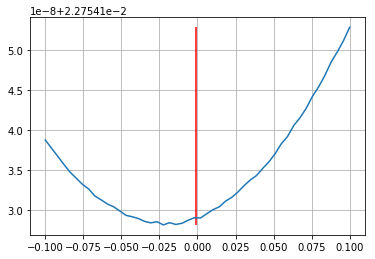

In [39]:
plt.plot(b , loss_from_t)
plt.grid()
plt.vlines(-0.0010 , min(loss_from_t)  , max(loss_from_t) , color = 'r')

In [43]:
min(loss_from_t) -  max(loss_from_t)
#оооооочень мало

-2.479553222467512e-08

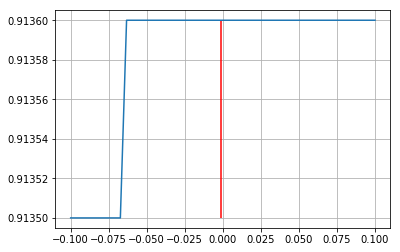

In [41]:
plt.plot(b , acc )
plt.grid()
plt.vlines(-0.0010 , min(acc)  , max(acc) , color = 'r')

In [24]:
 model.l1.weight[10][10] = o 

In [ ]:
o = model.l2.weight[10][10] 

In [25]:
o

tensor(0.1000, grad_fn=<AsStridedBackward>)

In [51]:
b = np.linspace(-5 , 0.3 , 20)
loss_from_t = []
acc = []
s = 0
for i in b:
    model.l2.weight[10][10] = i
    test_loss, accur = eva(test_loader , model)
    loss_from_t.append(test_loss)
    acc.append(accur)
    print(s)
    s += 1


Test set: Average loss: 0.0228, Accuracy: 9134/10000 (91%)

0

Test set: Average loss: 0.0228, Accuracy: 9134/10000 (91%)

1

Test set: Average loss: 0.0228, Accuracy: 9134/10000 (91%)

2

Test set: Average loss: 0.0228, Accuracy: 9134/10000 (91%)

3

Test set: Average loss: 0.0228, Accuracy: 9134/10000 (91%)

4

Test set: Average loss: 0.0228, Accuracy: 9134/10000 (91%)

5

Test set: Average loss: 0.0228, Accuracy: 9134/10000 (91%)

6

Test set: Average loss: 0.0228, Accuracy: 9135/10000 (91%)

7

Test set: Average loss: 0.0228, Accuracy: 9134/10000 (91%)

8

Test set: Average loss: 0.0228, Accuracy: 9134/10000 (91%)

9

Test set: Average loss: 0.0228, Accuracy: 9135/10000 (91%)

10

Test set: Average loss: 0.0228, Accuracy: 9137/10000 (91%)

11

Test set: Average loss: 0.0227, Accuracy: 9137/10000 (91%)

12

Test set: Average loss: 0.0227, Accuracy: 9137/10000 (91%)

13

Test set: Average loss: 0.0227, Accuracy: 9137/10000 (91%)

14

Test set: Average loss: 0.0227, Accuracy: 9135/10

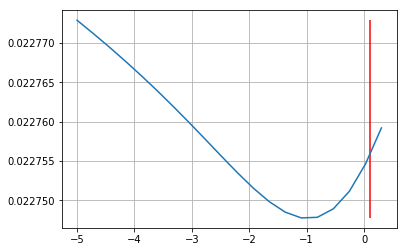

In [52]:
plt.plot(b , loss_from_t)
plt.grid()
plt.vlines(0.10 , min(loss_from_t)  , max(loss_from_t) , color = 'r')

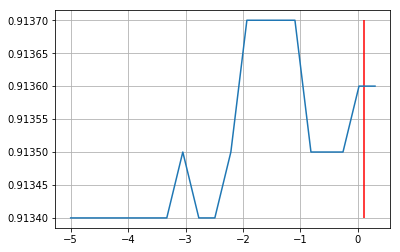

In [53]:
plt.plot(b , acc )
plt.grid()
plt.vlines(0.10 , min(acc)  , max(acc) , color = 'r')

In [54]:
 model.l2.weight[10][10] = o 

In [55]:
o = model.l3.weight[10][10] 

In [56]:
o

tensor(0.0644, grad_fn=<SelectBackward>)

In [68]:
b = np.linspace(-5 , 0.5 , 20)
loss_from_t = []
acc = []
s = 0
for i in b:
    model.l2.weight[10][10] = i
    test_loss, accur = eva(test_loader , model)
    loss_from_t.append(test_loss)
    acc.append(accur)
    print(s)
    s += 1


Test set: Average loss: 0.0228, Accuracy: 9134/10000 (91%)

0

Test set: Average loss: 0.0228, Accuracy: 9134/10000 (91%)

1

Test set: Average loss: 0.0228, Accuracy: 9134/10000 (91%)

2

Test set: Average loss: 0.0228, Accuracy: 9134/10000 (91%)

3

Test set: Average loss: 0.0228, Accuracy: 9134/10000 (91%)

4

Test set: Average loss: 0.0228, Accuracy: 9134/10000 (91%)

5

Test set: Average loss: 0.0228, Accuracy: 9134/10000 (91%)

6

Test set: Average loss: 0.0228, Accuracy: 9135/10000 (91%)

7

Test set: Average loss: 0.0228, Accuracy: 9134/10000 (91%)

8

Test set: Average loss: 0.0228, Accuracy: 9134/10000 (91%)

9

Test set: Average loss: 0.0228, Accuracy: 9137/10000 (91%)

10

Test set: Average loss: 0.0228, Accuracy: 9137/10000 (91%)

11

Test set: Average loss: 0.0227, Accuracy: 9137/10000 (91%)

12

Test set: Average loss: 0.0227, Accuracy: 9137/10000 (91%)

13

Test set: Average loss: 0.0227, Accuracy: 9136/10000 (91%)

14

Test set: Average loss: 0.0227, Accuracy: 9136/10

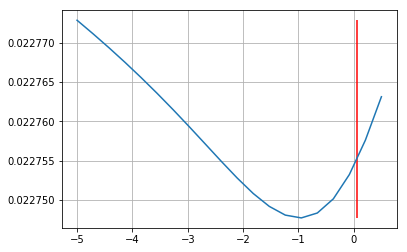

In [69]:
plt.plot(b , loss_from_t)
plt.grid()
plt.vlines(o.data , min(loss_from_t)  , max(loss_from_t) , color = 'r')

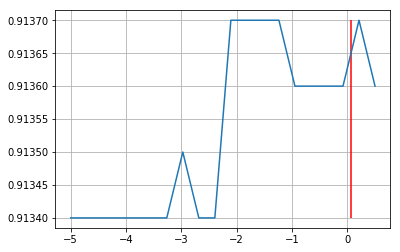

In [70]:
plt.plot(b , acc )
plt.grid()
plt.vlines(o.data, min(acc) , max(acc) , color = 'r')

In [72]:
model.l3.weight[10][10] = o 

In [74]:
o =  model.lf.weight[0][0]

tensor(0.1351, grad_fn=<SelectBackward>)

In [76]:
b = np.linspace(-2 , 0.5 , 20)
loss_from_t = []
acc = []
s = 0
for i in b:
    model.l2.weight[10][10] = i
    test_loss, accur = eva(test_loader , model)
    loss_from_t.append(test_loss)
    acc.append(accur)
    print(s)
    s += 1


Test set: Average loss: 0.0228, Accuracy: 9137/10000 (91%)

0

Test set: Average loss: 0.0228, Accuracy: 9138/10000 (91%)

1

Test set: Average loss: 0.0228, Accuracy: 9137/10000 (91%)

2

Test set: Average loss: 0.0227, Accuracy: 9137/10000 (91%)

3

Test set: Average loss: 0.0227, Accuracy: 9137/10000 (91%)

4

Test set: Average loss: 0.0227, Accuracy: 9137/10000 (91%)

5

Test set: Average loss: 0.0227, Accuracy: 9137/10000 (91%)

6

Test set: Average loss: 0.0227, Accuracy: 9137/10000 (91%)

7

Test set: Average loss: 0.0227, Accuracy: 9136/10000 (91%)

8

Test set: Average loss: 0.0227, Accuracy: 9135/10000 (91%)

9

Test set: Average loss: 0.0227, Accuracy: 9136/10000 (91%)

10

Test set: Average loss: 0.0227, Accuracy: 9135/10000 (91%)

11

Test set: Average loss: 0.0227, Accuracy: 9136/10000 (91%)

12

Test set: Average loss: 0.0228, Accuracy: 9135/10000 (91%)

13

Test set: Average loss: 0.0228, Accuracy: 9136/10000 (91%)

14

Test set: Average loss: 0.0228, Accuracy: 9136/10

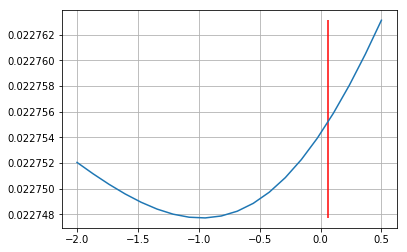

In [77]:
plt.plot(b , loss_from_t)
plt.grid()
plt.vlines(o.data , min(loss_from_t)  , max(loss_from_t) , color = 'r')

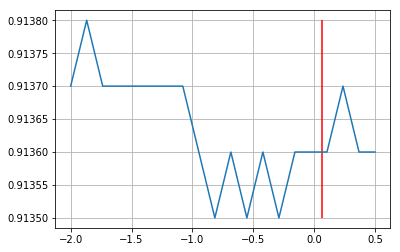

In [78]:
plt.plot(b , acc )
plt.grid()
plt.vlines(o.data, min(acc) , max(acc) , color = 'r')

# END

In [85]:
b = np.logspace(-4 ,4 , 10)

In [86]:
b

array([  1.00000000e-04,   7.74263683e-04,   5.99484250e-03,
         4.64158883e-02,   3.59381366e-01,   2.78255940e+00,
         2.15443469e+01,   1.66810054e+02,   1.29154967e+03,
         1.00000000e+04])

In [89]:
test_loss_from_var = []
accur_from_var = []
train_loss_history = []
for i in b:
    m_200 = i
    m_784 = i
    model = nn.Sequential()
    model.add_module('l1', nn.Linear(784, 200))
    model.add_module('r1', nn.Sigmoid())
    model.add_module('l2', nn.Linear(200, 200))
    model.add_module('r2', nn.Sigmoid())
    model.add_module('l3', nn.Linear(200, 200))
    model.add_module('r3', nn.Sigmoid())

    model.add_module('lf', nn.Linear(200, 10))

    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    #scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

    model.train()
    step = 0 
    loss_history = []
    for epoch in range(1, 4):
        for batch_idx, (data, target) in enumerate(trainloader):

            data, target = data.to(device), target.to(device)
            data = data.view(data.size(0), -1)
            optimizer.zero_grad()
            output = model(data)
            loss_0 = criterion(output, target)
            loss_1 = call_pr_loss(model.l1.weight , m_784)
            loss_2 = call_pr_loss(model.l2.weight , m_200)
            loss_3 = call_pr_loss(model.l3.weight , m_200)
            #loss_4 = call_pr_loss(model.l4.weight , m_200)
            loss_f = call_pr_loss(model.lf.weight , m_200)


            loss = loss_0 + loss_1+ loss_2+ loss_3  + loss_f
            loss.backward()
            optimizer.step()
            step += 1
            loss_history.append(loss.item())
            #if step % 1000  == 0:
        print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} '.format(
            epoch, batch_idx * len(data), len(trainloader.dataset),
            100. * batch_idx / len(trainloader), loss.item()))
        #scheduler.step()  
        
        
    test_loss, accur = eva(test_loader , model)
    
    test_loss_from_var.append(test_loss)
    accur_from_var.append(accur)
    train_loss_history.append(loss_history)
    

Train Epoch: 1 [59984/60000 (100%)]	Loss: -5097.884766 
Train Epoch: 2 [59984/60000 (100%)]	Loss: -5092.246094 
Train Epoch: 3 [59984/60000 (100%)]	Loss: -5078.269043 

Test set: Average loss: 0.1438, Accuracy: 1135/10000 (11%)

Train Epoch: 1 [59984/60000 (100%)]	Loss: -3683.096436 
Train Epoch: 2 [59984/60000 (100%)]	Loss: -3683.008057 
Train Epoch: 3 [59984/60000 (100%)]	Loss: -3682.772461 

Test set: Average loss: 0.1438, Accuracy: 1135/10000 (11%)

Train Epoch: 1 [59984/60000 (100%)]	Loss: -2266.745117 
Train Epoch: 2 [59984/60000 (100%)]	Loss: -2266.738281 
Train Epoch: 3 [59984/60000 (100%)]	Loss: -2266.715088 

Test set: Average loss: 0.1438, Accuracy: 1135/10000 (11%)

Train Epoch: 1 [59984/60000 (100%)]	Loss: -850.388672 
Train Epoch: 2 [59984/60000 (100%)]	Loss: -850.385437 
Train Epoch: 3 [59984/60000 (100%)]	Loss: -850.377869 

Test set: Average loss: 0.1438, Accuracy: 1135/10000 (11%)

Train Epoch: 1 [59984/60000 (100%)]	Loss: 565.935913 
Train Epoch: 2 [59984/60000 (100%

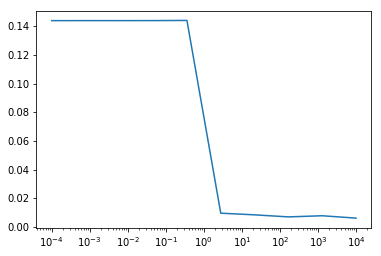

In [94]:
plt.semilogx(b , test_loss_from_var )

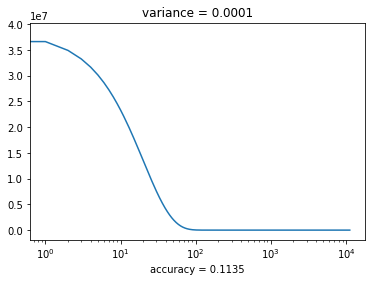

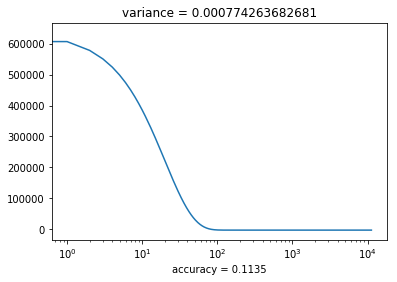

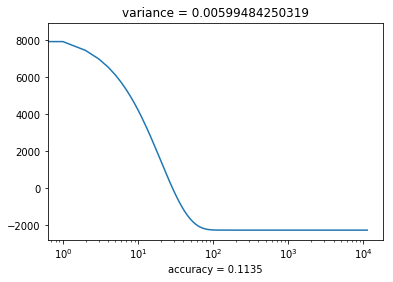

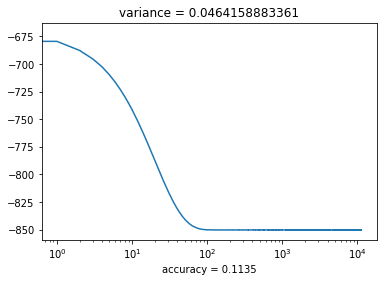

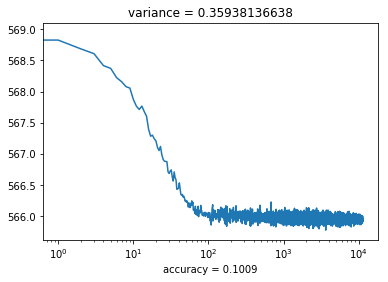

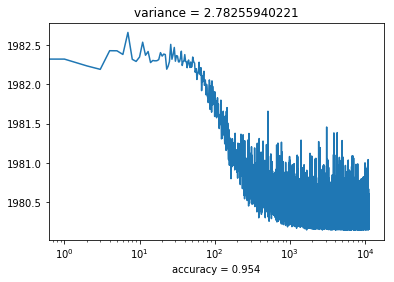

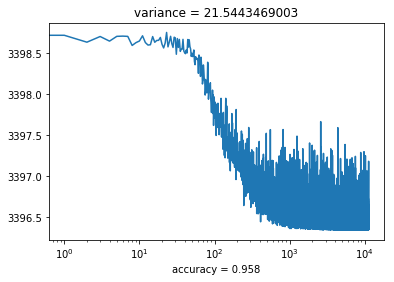

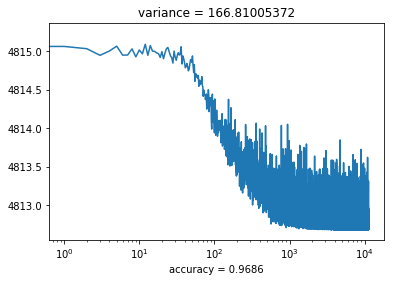

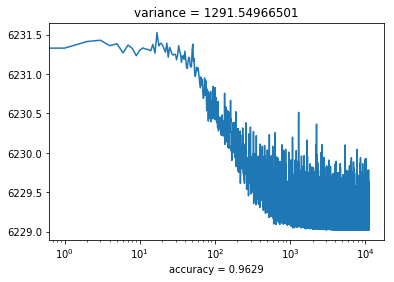

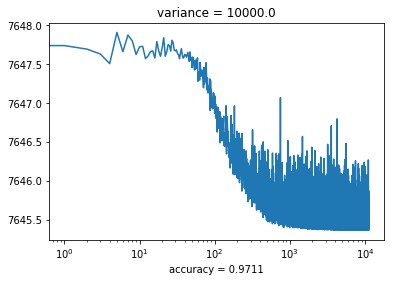

In [101]:
for i in range(len(b)):
    plt.figure()
    plt.semilogx(train_loss_history[i])
    plt.title('variance = ' + str(b[i]))
    plt.xlabel('accuracy = ' + str(accur_from_var[i]))
    plt.show()